In [327]:
pip install pymysql

In [328]:
pip install h2o

In [0]:
import pymysql
import pandas as pd
import datetime as dt
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import h2o
from h2o.frame import H2OFrame
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from h2o.estimators.random_forest import H2ORandomForestEstimator
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

### **Part 1: Load Dataset**
1.1 Read data from database

In [0]:
#spendevents data
db = pymysql.connect(host='34.217.198.153',user='jingjie',passwd='pg_Passw0rd',db='homework',port=3306,charset='latin1')
cursor = db.cursor()
spendevents = cursor.execute("select * from spendevents")
try:
   results = cursor.fetchall()
except:
   print ("Error: unable to fetch spendevents data")
spendevents = pd.DataFrame(results,columns=['udid','ts','date','story','chapter','spendtype','currency','amount'])

#iaps data
iaps = cursor.execute("select * from iaps")
try:
   results = cursor.fetchall()
except:
   print ("Error: unable to fetch iaps data")
iaps = pd.DataFrame(results,columns=['udid','ts','date','prod_name','prod_type','rev'])

#users data
users = cursor.execute("select * from users")
try:
   results = cursor.fetchall()
except:
   print ("Error: unable to fetch users data")
users = pd.DataFrame(results,columns=['udid','install_date','language','country','hw_ver','os_ver'])

#sessions data
sessions = cursor.execute("select udid, ts,date,session_num from sessions")
try:
   results = cursor.fetchall()
except:
   print ("Error: unable to fetch sessions data")
sessions = pd.DataFrame(results,columns=['udid','ts','date','session_num'])

1.2 Check all datasets' details

In [331]:
spendevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107764 entries, 0 to 107763
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   udid       107764 non-null  object        
 1   ts         107764 non-null  datetime64[ns]
 2   date       107764 non-null  object        
 3   story      107764 non-null  object        
 4   chapter    107764 non-null  int64         
 5   spendtype  107764 non-null  object        
 6   currency   107764 non-null  object        
 7   amount     107764 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 6.6+ MB


In [332]:
iaps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685 entries, 0 to 6684
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   udid       6685 non-null   object        
 1   ts         6685 non-null   datetime64[ns]
 2   date       6685 non-null   object        
 3   prod_name  6685 non-null   object        
 4   prod_type  6685 non-null   object        
 5   rev        6685 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 313.5+ KB


In [333]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722955 entries, 0 to 722954
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   udid         722955 non-null  object        
 1   ts           722955 non-null  datetime64[ns]
 2   date         722955 non-null  object        
 3   session_num  722955 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 22.1+ MB


In [334]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22576 entries, 0 to 22575
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   udid          22576 non-null  object
 1   install_date  22576 non-null  object
 2   language      22576 non-null  object
 3   country       22576 non-null  object
 4   hw_ver        22576 non-null  object
 5   os_ver        22576 non-null  object
dtypes: object(6)
memory usage: 1.0+ MB


There is no missing value in each dataset. 
Knowing the type of each feature here is important for later modeling

# **Part 2: Data Processing**


### 2.1 Label the non-payer and payer

non-payer:0     
payer:1

In [0]:
iaps['ifbuy'] = 1
iaps_user = pd.merge(left = users, right = iaps, on = 'udid', how = 'left')
iaps_user['ifbuy'].fillna(0,inplace = True)

### 2.2 Dealing features

 2.2.1 Convert date columns to date type


In [0]:
sessions['date'] = pd.to_datetime(sessions['date'])
iaps_user['date'] = pd.to_datetime(iaps_user['date'])
spendevents['date'] = pd.to_datetime(spendevents['date'])
iaps_user['install_date'] = pd.to_datetime(iaps_user['install_date'])

2.2.2 deal with iaps features


1.   
When the new user installs the game, we have no idea whether the user will convert or not. So all the detail information like ts, product, revenue can not be used in the model. But purchase date here is useful for our later data filter, so I will keep it for now.

In [0]:
iaps_user.drop(['ts','prod_name','prod_type','rev'],axis = 1,inplace = True)




2.   
Only care about the first time the user have the purchase action.
Create first_p_date: first time to make the purchase



In [0]:
first_p_date = iaps_user.groupby('udid').date.min().reset_index(name = 'first_p_date')
#iaps_user1 = pd.merge(left = iaps_user, right = first_p_date, how = 'left',on = 'udid')
iaps_user.drop(['date'],axis = 1,inplace = True)
iaps_user.drop_duplicates(inplace = True)

2.2.3 deal with session features


Create new feature: daily average login times per user (avg_login)

Create new feature: most frequent login hour per user (freq_hour)




Discuss non-payer and payer separately:

non-payer: calculate daily average login times/most frequent login hour for all times
           

payer: calculate daily average login times/most frequent login hour before first purchase.

In [0]:
session1 = pd.merge(left = first_p_date,right = sessions,how = 'left',on = 'udid')
session1['hour'] = session1['ts'].dt.hour
#non-payer
ses_non_total = session1.loc[session1['first_p_date'].isnull()].groupby(['udid','date']).session_num.size().reset_index(name = 'total_num_login')
ses_non_avg = ses_non_total.groupby('udid').total_num_login.mean().reset_index(name = 'avg_login')

ses_non_hour1 = session1.loc[session1['first_p_date'].isnull()].groupby(['udid']).hour.apply(pd.Series.mode).reset_index(name = 'freq_hour')
ses_non_hour = ses_non_hour1.groupby('udid').freq_hour.max().reset_index(name = 'freq_hour_m')
## no-session user
'''
non_ses = session1.loc[session1['date'].isnull(),['udid']]
non_ses['avg_login'] = 0
non_avg = pd.concat([ses_non_avg,non_ses])'''

#payer
ses_payer_total = session1.loc[session1['first_p_date'].notnull() & (session1['date'] < session1['first_p_date'])].groupby(['udid','date']).session_num.size().reset_index(name = 'total_num_login')
ses_payer_avg = ses_payer_total.groupby('udid').total_num_login.mean().reset_index(name = 'avg_login')

ses_payer_hour1 = session1.loc[session1['first_p_date'].notnull() & (session1['date'] < session1['first_p_date'])].groupby(['udid']).hour.apply(pd.Series.mode).reset_index(name = 'freq_hour')
ses_payer_hour = ses_payer_hour1.groupby('udid').freq_hour.max().reset_index(name = 'freq_hour_m')
## first time login payer
'''
all_payerid = session1.loc[session1['first_p_date'].notnull(),['udid']]
all_payerid.drop_duplicates(inplace = True)
payer_avg = pd.merge(left = all_payerid,right =ses_payer_avg,how = 'left',on = 'udid' )
payer_avg['avg_login'].fillna(0,inplace = True)'''

#combine two types of users
ses_avg = pd.concat([ses_non_avg,ses_payer_avg])
ses_hour = pd.concat([ses_non_hour,ses_payer_hour])


2.2.4 deal with spendevents features


Create new feature: daily average gems spend per user (avg_spent)

Create new feature: daily average gems earned per user, not including purchases (avg_earned)



Discuss non-payer and payer separately:

non-payer: calculate daily average gems spent/earned for all times

payer: calculate daily average gems spent/earned before first purchase.

In [0]:
spendevents1 = pd.merge(left = first_p_date,right = spendevents,how = 'left',on = 'udid')

#non-payer
spent_non_total = spendevents1.loc[spendevents1['first_p_date'].isnull() & (spendevents1['amount'] > 0)].groupby(['udid','date']).amount.sum().reset_index(name = 'total_spent')
spent_non_avg = spent_non_total.groupby('udid').total_spent.mean().reset_index(name = 'avg_spent')

earn_non_total = spendevents1.loc[spendevents1['first_p_date'].isnull() & (spendevents1['amount'] < 0)& (spendevents1['spendtype']!='IAP')].groupby(['udid','date']).amount.sum().reset_index(name = 'total_earned')
earn_non_avg = earn_non_total.groupby('udid').total_earned.mean().reset_index(name = 'avg_earned')

#payer
spent_payer_total = spendevents1.loc[spendevents1['first_p_date'].notnull() & (spendevents1['date'] < spendevents1['first_p_date']) & (spendevents1['amount'] > 0)].groupby(['udid','date']).amount.sum().reset_index(name = 'total_spent')
spent_payer_avg = spent_payer_total.groupby('udid').total_spent.mean().reset_index(name = 'avg_spent')

earn_payer_total = spendevents1.loc[spendevents1['first_p_date'].notnull() & (spendevents1['date'] < spendevents1['first_p_date'])& (spendevents1['spendtype']!='IAP') & (spendevents1['amount'] < 0)].groupby(['udid','date']).amount.sum().reset_index(name = 'total_earned')
earn_payer_avg = earn_payer_total.groupby('udid').total_earned.mean().reset_index(name = 'avg_earned')

#combine two types of users
spent_avg = pd.concat([spent_non_avg,spent_payer_avg])
earn_avg = pd.concat([earn_non_avg,earn_payer_avg])

### 2.3 Merge all dataset together

In [0]:
iaps_user_spend = pd.merge(left = iaps_user, right = spent_avg, on = 'udid',how ='left')
iaps_user_spend_ses = pd.merge(left = iaps_user_spend, right = ses_avg, on = 'udid',how ='left')
iaps_user_spend_ses_earn = pd.merge(left = iaps_user_spend_ses, right = earn_avg, on = 'udid',how ='left')
all_data = pd.merge(left = iaps_user_spend_ses_earn, right = ses_hour, on = 'udid',how ='left')

In [342]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22576 entries, 0 to 22575
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   udid          22576 non-null  object        
 1   install_date  22576 non-null  datetime64[ns]
 2   language      22576 non-null  object        
 3   country       22576 non-null  object        
 4   hw_ver        22576 non-null  object        
 5   os_ver        22576 non-null  object        
 6   ifbuy         22576 non-null  float64       
 7   avg_spent     3260 non-null   float64       
 8   avg_login     21818 non-null  float64       
 9   avg_earned    17222 non-null  float64       
 10  freq_hour_m   21818 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 2.1+ MB


2.3.1 Filling all the missing value with 0

In [0]:
all_data[['avg_spent','avg_login','avg_earned','freq_hour_m']] = all_data[['avg_spent','avg_login','avg_earned','freq_hour_m']].fillna(0)

2.3.2 Drop install date(irrelevent)

In [0]:
all_data = all_data.drop(['install_date'],axis = 1)

# **Part 3: Modeling**


[Text(0.5, 1.0, 'non-payer vs in app purchase ')]

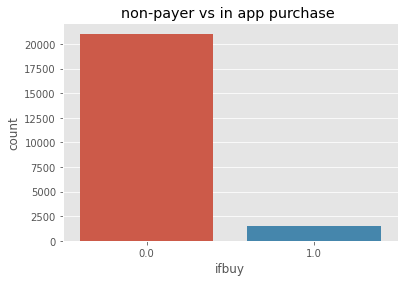

In [345]:
sns.countplot(x='ifbuy', data=all_data).set(title = 'non-payer vs in app purchase ')

This dataset is a very inbalanced dataset, that's why we need to split proportionally.

### 3.1 Spilt the dataset into train(train + validation) and test set with the same ratio of two types of users

In [0]:
#payer:
payer_X = all_data.loc[all_data['ifbuy']==1].drop(['ifbuy'],axis = 1)
payer_Y = all_data.loc[all_data['ifbuy']==1,['ifbuy']]

#non-payer
non_X = all_data.loc[all_data['ifbuy']==0].drop(['ifbuy'],axis = 1)
non_Y = all_data.loc[all_data['ifbuy']==0,['ifbuy']]

In [0]:
X_p_train_t, X_p_test, y_p_train_t, y_p_test = train_test_split(payer_X, payer_Y, test_size=0.2,random_state = 5)
X_p_train, X_p_val, y_p_train, y_p_val = train_test_split(X_p_train_t, y_p_train_t, test_size=0.1,random_state = 8)

X_n_train_t, X_n_test, y_n_train_t, y_n_test = train_test_split(non_X, non_Y, test_size=0.2,random_state = 3)
X_n_train, X_n_val, y_n_train, y_n_val = train_test_split(X_n_train_t, y_n_train_t, test_size=0.1,random_state = 8)

X_train = pd.concat([X_p_train,X_n_train])
Y_train = pd.concat([y_p_train,y_n_train])
train = pd.concat([X_train,Y_train],axis = 1)

X_val = pd.concat([X_p_val,X_n_val])
Y_val = pd.concat([y_p_val,y_n_val])
val = pd.concat([X_val,Y_val],axis = 1)

X_test = pd.concat([X_p_test,X_n_test])
Y_test = pd.concat([y_p_test,y_n_test])
test = pd.concat([X_test,Y_test],axis = 1)


### 3.2 Implement random forest model

In [348]:
h2o.init()
h2o_X_train = H2OFrame(X_train,column_types={'os_ver': 'enum','freq_hour_m': 'enum'})
h2o_Y_train = H2OFrame(Y_train,column_types={'ifbuy': 'enum'})
h2o_X_val = H2OFrame(X_val,column_types={'os_ver': 'enum','freq_hour_m': 'enum'})
h2o_Y_val = H2OFrame(Y_val,column_types={'ifbuy': 'enum'})
h2o_X_test = H2OFrame(X_test,column_types={'os_ver': 'enum','freq_hour_m': 'enum'})
h2o_Y_test = H2OFrame(Y_test,column_types={'ifbuy': 'enum'})
h2o_train = H2OFrame(train,column_types={'os_ver': 'enum','ifbuy': 'enum','freq_hour_m': 'enum'})
h2o_val = H2OFrame(val,column_types={'os_ver': 'enum','ifbuy': 'enum','freq_hour_m': 'enum'})
h2o_test = H2OFrame(test,column_types={'os_ver': 'enum','ifbuy': 'enum','freq_hour_m': 'enum'})

h2o_train.summary()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 46 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_51o9ww
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.621 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


,udid,language,country,hw_ver,os_ver,avg_spent,avg_login,avg_earned,freq_hour_m,ifbuy
type,string,enum,enum,enum,enum,real,real,real,enum,enum
mins,NaN,,,,,0.0,0.0,-3000026.0,,
mean,NaN,,,,,3.5783162877554164,3.541461013395765,-206.14231097146816,,
maxs,NaN,,,,,308.3529411764706,76.75,0.0,,
sigma,NaN,,,,,9.840787193394812,3.3736577246225403,23531.080252400418,,
zeros,0,,,,,13926,539,3863,,
missing,0,0,0,0,0,0,0,0,0,0
0,76863014f8d145a0a37517bed8a82aa4,tr,TR,"iPhone7,1",9.2.1,0.0,25.0,-22.0,14.0,1.0
1,8afc44b879a94b5b946a39b78075c744,en,US,"iPhone8,1",9.2.1,0.0,20.0,-22.0,11.0,1.0
2,e6c7cb751ace409c8f77d2d9e00f31e8,en,GB,"iPhone7,1",9.2.1,0.0,1.5,-22.0,14.0,1.0


In [0]:
#Define the grid parameters
estimator = H2ORandomForestEstimator(
    # Stops fitting new trees when 10-tree rolling average is within 0.00001
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    score_each_iteration = True,
    stopping_metric = 'auc',
    balance_classes = True,
    seed = 7)

hyper_parameters = {'ntrees':[5, 10, 20, 30, 40, 50, 60], 
                    'max_depth':[5, 10, 20, 30, 40, 50, 60]}

criteria = {"strategy": "RandomDiscrete", 
            "stopping_rounds": 10,
            "stopping_tolerance": 0.00001,
            "stopping_metric": "misclassification"}

grid_search = H2OGridSearch(model = estimator, 
                            hyper_params = hyper_parameters,
                            search_criteria = criteria)

In [350]:
#Now train the network
feature = ['language','country','hw_ver','os_ver','avg_spent','avg_login','avg_earned','freq_hour_m']
target = 'ifbuy'

grid_search.train(x = feature,
                  y = target,
                  training_frame = h2o_train,
                  validation_frame = h2o_val)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [351]:
#Sort the grid models by decreasing AUC
sorted_grid = grid_search.get_grid(sort_by='auc',decreasing=True)
# print('Best model sorted by auc:\n', sorted_grid.models[0])

best_max_depth  = sorted_grid.sorted_metric_table()['max_depth'][0]
best_ntrees     = sorted_grid.sorted_metric_table()['ntrees'][0]
best_auc        = sorted_grid.sorted_metric_table()['auc'][0]
sorted_grid_mse = grid_search.get_grid(sort_by='mse',decreasing=True)
best_mse        = sorted_grid_mse.sorted_metric_table()['mse'][0]

print('Best max_depth.....', best_max_depth)
print('Best ntrees........', best_ntrees)
print('Best auc...........', best_auc)
print('Best mse...........', best_mse)

Best max_depth..... 5
Best ntrees........ 40
Best auc........... 0.856657158989136
Best mse........... 0.0419229442421989


In [352]:
#Now let’s use the best parameters
best_rf = H2ORandomForestEstimator(
    model_id = "best_rf",
    ntrees = int(best_ntrees),
    max_depth = int(best_max_depth),
    stopping_rounds = 5,
    stopping_metric = 'auc',
    score_each_iteration = True,
    balance_classes = True,
    seed = 7)

best_rf.train(feature, 
              target, 
              training_frame = h2o_train, 
              validation_frame = h2o_val)

drf Model Build progress: |███████████████████████████████████████████████| 100%


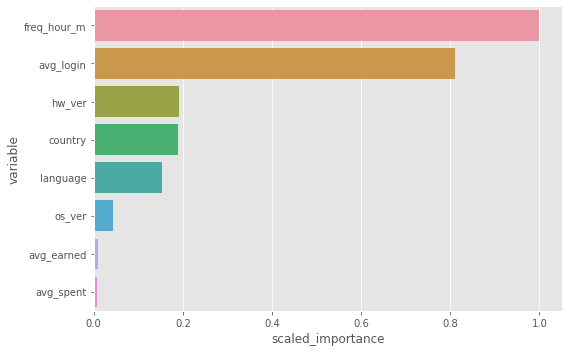

In [353]:
# Feature importance
importance = best_rf.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

we can see from the importance graph above, frequent hour, daily average earned, daily login,hw version seems to be the most importance features here.

In [354]:
print(classification_report(y_true=h2o_Y_test.as_data_frame().values, y_pred = predictions['predict'].as_data_frame().values))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      4210
         1.0       0.76      0.65      0.70       306

    accuracy                           0.96      4516
   macro avg       0.87      0.82      0.84      4516
weighted avg       0.96      0.96      0.96      4516



The performance here is fine, F1 socre here for both non-payer and payer prediction is above 0.7.

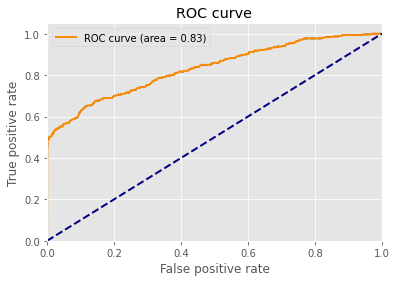

In [355]:
def ROC_Curve(model, df):
    performance = model.model_performance(df)  
    auc = performance.auc()
    false_positive_rate = performance.fprs
    true_positive_rate = performance.tprs

    plt.style.use('ggplot')
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, 'k--')
    plt.plot(false_positive_rate, 
             true_positive_rate, 
             color='darkorange',
             lw = 2,
             label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
ROC_Curve(best_rf, h2o_test)

Model on the testing dataset perform pretty well based on ROC curve. AUC reaches 0.83

In [356]:
all_data.head()

,udid,language,country,hw_ver,os_ver,ifbuy,avg_spent,avg_login,avg_earned,freq_hour_m
0,f22d7b9cbc03439e9b9db52725b439fc,en,AU,"iPhone4,1",8.4,0.0,0.0,1.0,-22.0,1.0
1,4f88b3047dbb4637b5b46a011a2aa3d9,de,CH,"iPhone7,2",9.2.1,0.0,0.0,3.0,-44.0,4.0
2,d92be71922e24c2f8b1bc034171d23ba,it,IT,"iPad3,3",9.2.1,0.0,0.0,4.5,-44.0,4.0
3,c8ea7938be1b43c7b504fc2b85563417,en,US,"iPhone7,2",9.2.1,0.0,0.0,2.8,-22.0,17.0
4,3bbc06e684724fdaa30995075641049c,nl,NL,"iPhone6,2",9.2.1,0.0,0.0,3.0,-54.0,5.0


# Part 4: Feature Analysis and Visualization


### 4.1 Most frequent login hour

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


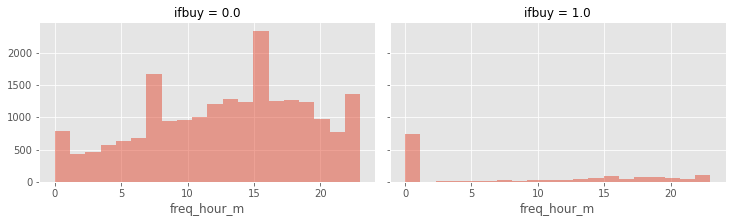

In [357]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(all_data, col='ifbuy', size=3.2, aspect=1.6)
grid.map(plt.hist, 'freq_hour_m', alpha=.5, bins=20)
grid.add_legend();

From the grapy above, we can see that for non-payer, there are 4 peaks that they are most frequently playing the games: around 0am, 7am, 4pm, 11pm

For payers, they are most likey playing around 0am.

In [0]:
num_hour = all_data.groupby(['freq_hour_m','ifbuy']).size().reset_index(name = 'num_hour')
num_hour_payer = num_hour.loc[num_hour['ifbuy']==1,['freq_hour_m','ifbuy','num_hour']]
total = num_hour.groupby('freq_hour_m').num_hour.sum().reset_index(name = 'total')
hour_data = pd.merge(left = num_hour_payer,right = total,on = 'freq_hour_m')
hour_data['conversion rate'] = hour_data['num_hour'] /hour_data['total']

[Text(0.5, 1.0, 'frequent hour distribution')]

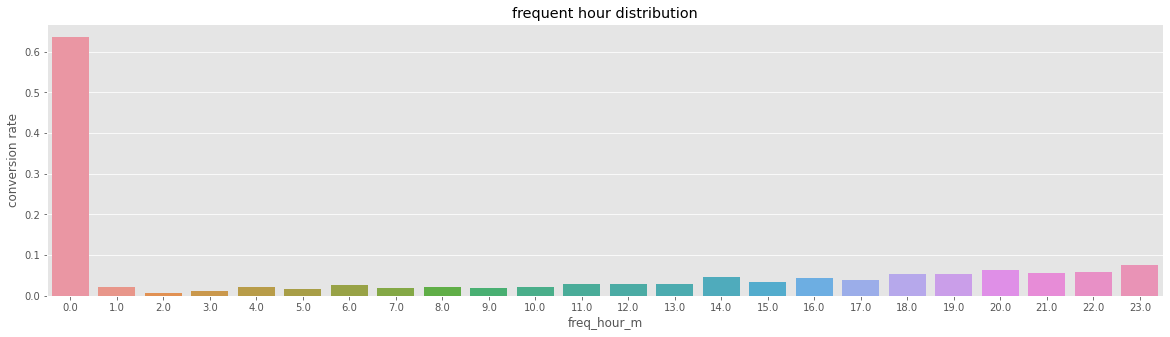

In [359]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
sns.barplot(x='freq_hour_m',y = 'conversion rate', data=hour_data).set(title = 'frequent hour distribution')

From the hour distribution graph, we can see that 0am has the highest conversion rate. Besides 0am, it seems users are more likely to pay during night times.

### 4.2 Daily average login times

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


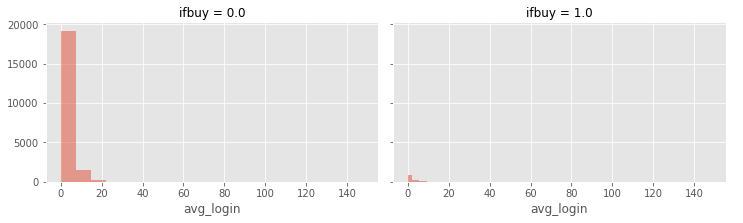

In [360]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
all_data['avg_login'] = round(all_data['avg_login'],0)
grid = sns.FacetGrid(all_data, col='ifbuy', size=3.2, aspect=1.6)
grid.map(plt.hist, 'avg_login', alpha=.5, bins=20)
grid.add_legend();

In [0]:
login_num = all_data.groupby(['avg_login','ifbuy']).size().reset_index(name = 'login_num')
login_num_payer = login_num.loc[login_num['ifbuy']==1,['avg_login','ifbuy','login_num']]
total1 = login_num.groupby('avg_login').login_num.sum().reset_index(name = 'total')
login_data = pd.merge(left = login_num_payer,right = total1,on = 'avg_login')
login_data['conversion rate'] = login_data['login_num'] /login_data['total']

[Text(0.5, 1.0, 'daily login times distribution')]

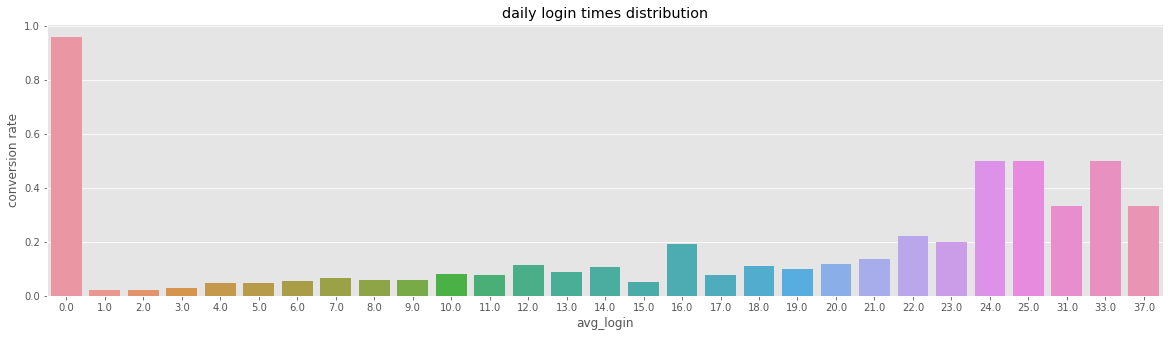

In [362]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
sns.barplot(x='avg_login',y = 'conversion rate', data=login_data).set(title = 'daily login times distribution')

From the daily login times distribution, we can see that users with 0 or 24-37 login times daily are most likely converted. 0 login times might be caused by information loss problem, we can ignore it. It seems that users who often play games are more likely pay.

### 4.3 OS Version type

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


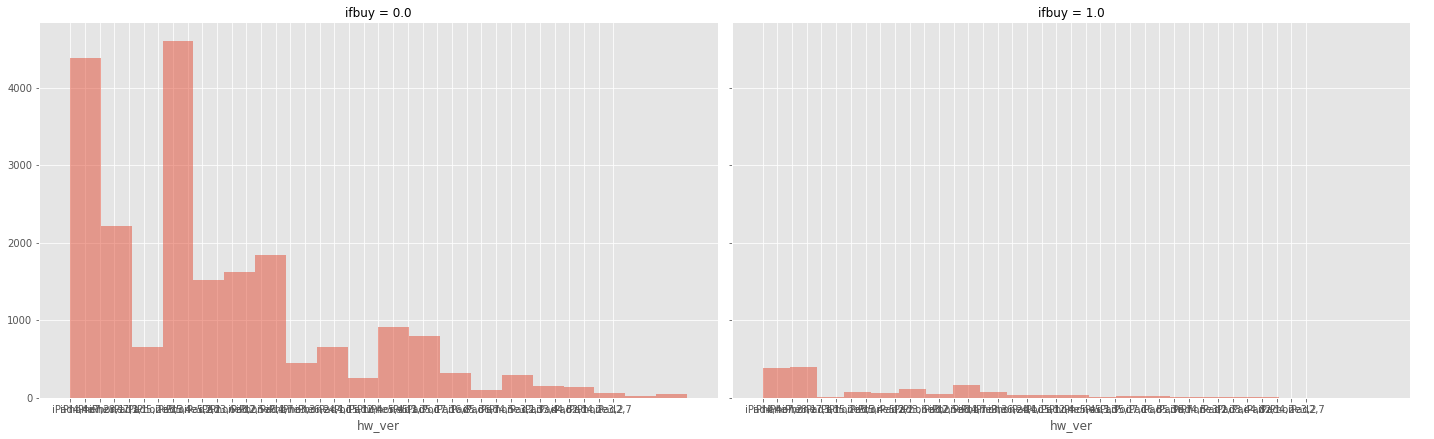

In [369]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(all_data, col='ifbuy', size=6.2, aspect=1.6)
grid.map(plt.hist, 'hw_ver', alpha=.5, bins=20)
grid.add_legend();

[Text(0.5, 1.0, 'hw_ver distribution')]

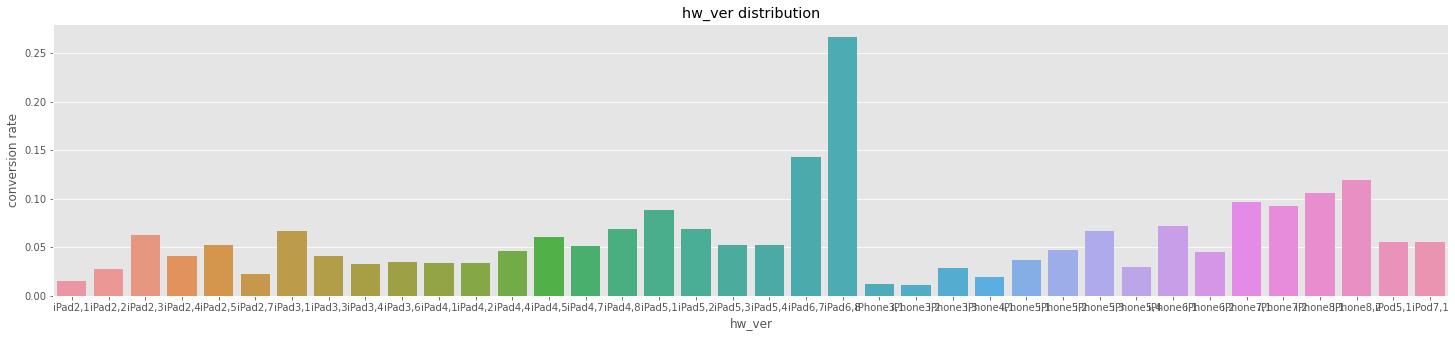

In [377]:
hw_ver_num = all_data.groupby(['hw_ver','ifbuy']).size().reset_index(name = 'hw_ver_num')
hw_ver_num_payer = hw_ver_num.loc[hw_ver_num['ifbuy']==1,['hw_ver','ifbuy','hw_ver_num']]
total2 = hw_ver_num.groupby('hw_ver').hw_ver_num.sum().reset_index(name = 'total')
hw_ver_data = pd.merge(left = hw_ver_num_payer,right = total2,on = 'hw_ver')
hw_ver_data['conversion rate'] = hw_ver_data['hw_ver_num'] /hw_ver_data['total']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 5))
sns.barplot(x='hw_ver',y = 'conversion rate', data=hw_ver_data).set(title = 'hw_ver distribution')

From the graph above, we notice that users who are using ipad 6.7 or 6.8 are more likely to convert.

### 4.4 Country

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


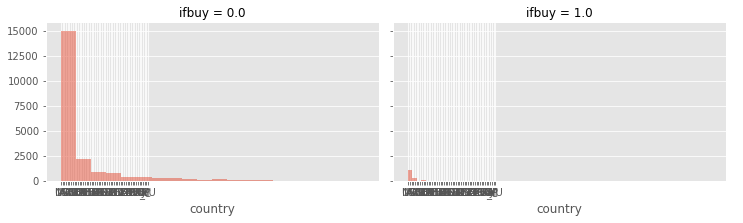

In [379]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(all_data, col='ifbuy', size=3.2, aspect=1.6)
grid.map(plt.hist, 'country', alpha=.5, bins=20)
grid.add_legend();

[Text(0.5, 1.0, 'country distribution')]

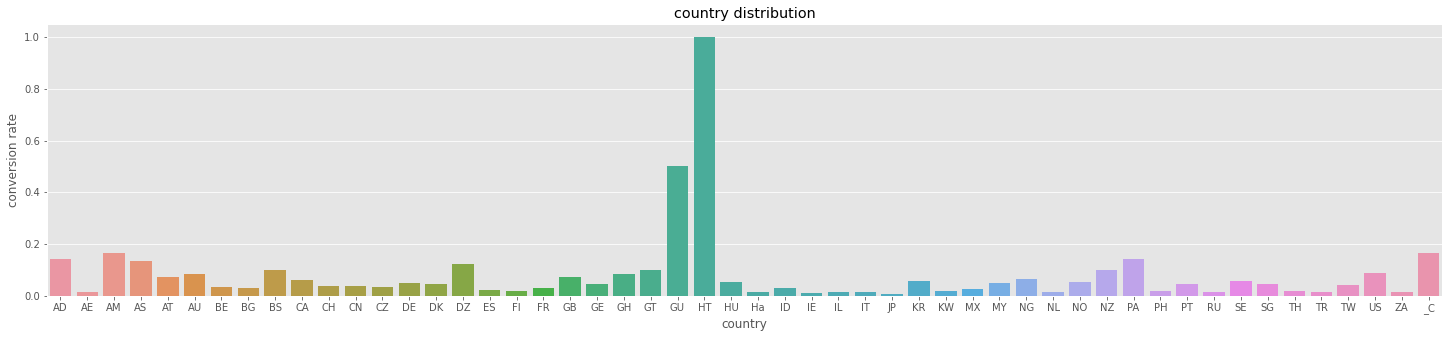

In [383]:
country_num = all_data.groupby(['country','ifbuy']).size().reset_index(name = 'country_num')
country_num_payer = country_num.loc[country_num['ifbuy']==1,['country','ifbuy','country_num']]
total3 = country_num.groupby('country').country_num.sum().reset_index(name = 'total')
country_num_data = pd.merge(left = country_num_payer,right = total3,on = 'country')
country_num_data['conversion rate'] = country_num_data['country_num'] /country_num_data['total']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 5))
sns.barplot(x='country',y = 'conversion rate', data=country_num_data).set(title = 'country distribution')

From the country distribution graph above, we can see users from AD, AM, AS,BS,DZ,GU,PA,NZ,US seems have higher conversion rate. HT is the special case here, because few people from HT 

# Part 5: Conclusion

Among all our users, there are three features that payers are more likely to have:

1. Users who likes playing at night are more likely to convert.
2. Users who are using ipad 6.7 or 6.8 are more likely to convert.
3. Users from AD, AM, AS,BS,DZ,GU,PA,NZ,US are more likely to convert.

We have trained the model using limited datasets here. With more data obtained, we can train our model again to get a better performanced model.

When a user plays for a short time and still haven't convert,  we can use this users feature to predict if he is likely to convert by himself or it is better we offer him the promotion encouraging him to pay.